<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Visualizing-Solutions-to-Partial-Differential-Equations" data-toc-modified-id="Visualizing-Solutions-to-Partial-Differential-Equations-1">Visualizing Solutions to Partial Differential Equations</a></span><ul class="toc-item"><li><span><a href="#Solving-The-Heat-Equation-(Laplace's-Equation)-with-Python" data-toc-modified-id="Solving-The-Heat-Equation-(Laplace's-Equation)-with-Python-1.1">Solving The Heat Equation (Laplace's Equation) with Python</a></span><ul class="toc-item"><li><span><a href="#Simplification-and-Spatial-Discretization-of-The-Steady-State-Heat-Equation-in-2D-and-3D-cartesian-coordinates." data-toc-modified-id="Simplification-and-Spatial-Discretization-of-The-Steady-State-Heat-Equation-in-2D-and-3D-cartesian-coordinates.-1.1.1">Simplification and Spatial Discretization of The Steady State Heat Equation in 2D and 3D cartesian coordinates.</a></span><ul class="toc-item"><li><span><a href="#Relaxation-Method" data-toc-modified-id="Relaxation-Method-1.1.1.1">Relaxation Method</a></span></li></ul></li><li><span><a href="#Visualizing-The-Solution" data-toc-modified-id="Visualizing-The-Solution-1.1.2">Visualizing The Solution</a></span><ul class="toc-item"><li><span><a href="#Reusable-Code" data-toc-modified-id="Reusable-Code-1.1.2.1">Reusable Code</a></span></li></ul></li></ul></li><li><span><a href="#Solving-the-Heat-Flow-(Schroedinger)-Equation" data-toc-modified-id="Solving-the-Heat-Flow-(Schroedinger)-Equation-1.2">Solving the Heat Flow (Schroedinger) Equation</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Rethinking-discretization-of-Laplace's-Equation" data-toc-modified-id="Rethinking-discretization-of-Laplace's-Equation-1.2.0.1">Rethinking discretization of Laplace's Equation</a></span></li></ul></li><li><span><a href="#Warm-Handprint-on-Surface-(Cool!)" data-toc-modified-id="Warm-Handprint-on-Surface-(Cool!)-1.2.1">Warm Handprint on Surface (Cool!)</a></span></li></ul></li><li><span><a href="#Circulation,-Curl,-and-Stokes'-Theorem;-the-Fundamental-Theorems-of-Vector-Calculus" data-toc-modified-id="Circulation,-Curl,-and-Stokes'-Theorem;-the-Fundamental-Theorems-of-Vector-Calculus-1.3">Circulation, Curl, and Stokes' Theorem; the Fundamental Theorems of Vector Calculus</a></span></li></ul></li></ul></div>

I used these __Additional Resources:__
1. Computational Physics with Python by Dr. Eric Ayars of California State University, Chico. <a href="http://www.fizika.unios.hr/rf/wp-content/uploads/sites/67/2011/02/CPwP.pdf">Available for download (PDF) here</a>.
2. <a href="https://www.codeproject.com/articles/1087025/%2fArticles%2f1087025%2fUsing-Python-to-Solve-Computational-Physics-Proble">Using Python to Solve Computational Physics Problems</a> by Garbel Nervadof on Code Project. __*Note that Code Project author incorrectly coded the boundary conditions. I've fixed the error, as demonstrated by my code below*__

__Optimizing performance:__
The discretized solution to Laplace's Equation is extra bad (the good kind of bad) because it is very, very easily compiled into C code using just-in-time compiling.

Even better, we can <a href="https://numba.pydata.org/numba-doc/0.11/prange.html">parallelize the computation</a> or even use CUDA to run the computations on our GPU. If we want to calculate complicated heat transfer or charge distributions, we can make the computations wicked fast (compared to single-threaded CPU computing) with almost no additional effort. The only caveat is that parallelizing and GPU computing require that we use use Python built-ins exclusively... so no numpy arrays.

More information can be found here.
https://murillogroupmsu.com/julia-set-speed-comparison/

For convenience we'll use NumPy since its familiar and written on top of C/C++. We'll use Numpy + Just-In-Time compiling to give a drastic speed boost to calculating the steady state distribution. We'll use Numpy for the Heat Flow problems--we can use `@jit` compiling as well, but we won't see much of a boost.

*After giving JIT a shot I found that the arrays of data were behaving in an unexcpected way. I wasn't able to figure out in a timely manner what the issue was. JIT seems to work perfectly well for calculating the steady state distribution, but the time series wasn't responding well. I believe that Numba may be attempting to parallelize the computations, which become unstable during parallel computation. Patches of the output images seemed to be clipped away, containing NaN values.*

*Nonetheless, the code is pretty fast.*

I read but *did not* use code/math from these __Additional Resources:__

3. <a href="https://fenicsproject.org/pub/tutorial/html/._ftut1001.html#table_of_contents">Fenics Project: Solving PDEs with Python</a>

4. <a href="https://hinderedsettling.com/2015/02/06/exploring-the-diffusion-equation-with-python/">Exploring the Diffusion Equation with Python</a>

5. <a href="http://www.math-cs.gordon.edu/courses/mat342/python.html">Gordon College of Mathematics and Science: Python for Computation Mathematics and Physics Demos and Projects</a>

6. <a href="https://nbviewer.jupyter.org/github/barbagroup/CFDPython/tree/master/lessons/">Dr. Lorena A. Barbara's 12-Step Crash Course in Python for Fluid Dynamics</a>

# Visualizing Solutions to Partial Differential Equations

__Goals:__

1) Use Python and simulations to visualize solutions to some physical situations that are modeled by partial differential equations.

2) Get ahead on Week 9 MVVC reading

## Solving The Heat Equation (Laplace's Equation) with Python

Laplace's Equation for heat conduction can be given in 3D as follows:

$$ \frac{\partial{^2T}}{\partial{x^2}} + \frac{\partial{^2T}}{\partial{y^2}} + \frac{\partial{^2T}}{\partial{z^2}} = 0$$

We only have to solve the heat equation for idealized plates in two dimensions. We'll represent Laplace's Equation in three dimensions, and easily adapt the method to two dimensions.<br /><br />


To do this with *Python* we'll have to break space into a grid of evenly spaced discrete points. We'll develop a simplified expression of Laplace's Equation and use it to solve for the potential $T$. Very quickly in the discretization process we'll find out something very exciting: the value of $T$ at a given point in the grid is the average of all its neighboring points.<br /><br />


We'll only have to write and algorithm that passes over our grid until the change in value of a point is below our pre-determined tolerance... since we'll be working with very simple systems we can just set the number of passes to a sufficiently high value without having to worry about computation time or precision.

### Simplification and Spatial Discretization of The Steady State Heat Equation in 2D and 3D cartesian coordinates.

See <a href="http://www.fizika.unios.hr/rf/wp-content/uploads/sites/67/2011/02/CPwP.pdf">Computational Physics with Python by Dr. Eric Ayars of California State University,</a> beginning at page 141.

We can write the first derivative of $T$ with respect to $x$ at $x = x_{i+\frac{1}{2}}$ as the approximation:

$$\frac{\partial{T}}{\partial{x}} \approx \frac{T(x_{i+1}) - T(x_{i-1})}{\Delta x}$$

We simplify our notation such that
$$T(x_i) = T_i$$ 
$$T(x_{i+1},y_{j},z_{k}) = T_{i+1,j,k}$$
$$T(x_{i},y_{j},z_{k}) = T_{ijk}$$

Similarly we can write

$$\frac{\partial{T_{i-\frac{1}{2}}}}{\partial{x}} \approx \frac{T_{i} - T_{i-1}}{\Delta x}$$

We need to find each $T_i$, so:

$$\frac{\partial{T_i}}{\partial{x}} \approx \frac{T(x_{i+\frac{1}{2}}) - T(x_{i-\frac{1}{2}})}{\Delta x}$$

We've been working with first derivatives. What we really need is the *second* derivative:

$$\frac{\partial{^2T_i}}{\partial{x^2}} \approx \frac{T(x_{i+\frac{1}{2}}) - T(x_{i-\frac{1}{2}})}{\Delta x^2}$$

Now we plug this back into Laplace's Equation and simplify. There will appear to be a bit of a jump to the expression for $T_{ijk}$ that's given next, but it works out very simply on paper:

$$T_{ijk} = \frac{1}{6}[T_{i+1,j,k}+T_{i-1,j,k}+T_{i,+1j,k}+T_{i,j-1,k}+T_{i,j,k+1}+T_{i,j,k-1}]$$

As it turns out, what this tells us is that on a grid of evenly spaced discrete points, the temperature at a given point is equal to the average of the temperature of all the points around it. Cool!

In two dimensions it is even more simple and works out to be:

$$T_{ij} = \frac{1}{4}[T_{i+1,j,}+T_{i-1,j,}+T_{i,+1j,}+T_{i,j-1,}]$$

Once you work this out on paper, head over to <a href="https://www.codeproject.com/articles/1087025/%2fArticles%2f1087025%2fUsing-Python-to-Solve-Computational-Physics-Proble">the Code Project article</a> and look at the illustrations and the code. It will make even more sense.

#### Relaxation Method

The *relaxation method* entails giving a guess as to average value of the temperature over the whole plate. It can start at zero, but even the roughest guess will speed up calculation if its closer than zero to the average value across the plate. This won't effect the end result, just the calculation time.

### Visualizing The Solution

Consider a plate with dimensions $10cm \times 20cm$.

The Temperature on the bottom and top sides of the plate is held at 100 degrees, and zero on the left and right sides.

For our relaxation we'll choose a starting guess of 20 degrees.

#### Reusable Code

This can be resued for any rectangular plate in 2 dimensions.

Initial Temperatures across plate:
 [[100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
 [  0.  30.  30.  30.  30.  30.  30.  30.  30.   0.]
 [  0.  30.  30.  30.  30.  30.  30.  30.  30.   0.]
 [  0.  30.  30.  30.  30.  30.  30.  30.  30.   0.]
 [  0.  30.  30.  30.  30.  30.  30.  30.  30.   0.]
 [  0.  30.  30.  30.  30.  30.  30.  30.  30.   0.]
 [  0.  30.  30.  30.  30.  30.  30.  30.  30.   0.]
 [  0.  30.  30.  30.  30.  30.  30.  30.  30.   0.]
 [  0.  30.  30.  30.  30.  30.  30.  30.  30.   0.]
 [  0.  30.  30.  30.  30.  30.  30.  30.  30.   0.]]


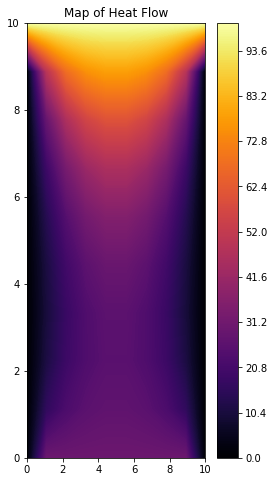

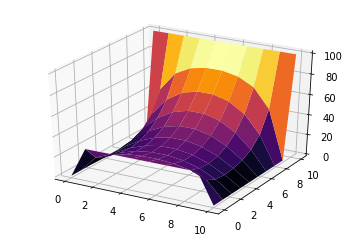

In [81]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy as np
%matplotlib inline

# Set the number of iterations through our grid of data points
# This means we assume it converges within 550 iterations
maxiter = 500

# Set dimensions of our plate and the delta (step size in x- and y- directions)
lenx, leny = 10, 10
delta = 1

# Bountary conditions
Ttop = 100
Tbottom = 30
Tleft = 0
Tright = 0

# Initial guess of interior temp (relaxation)
Tguess = 30

# Set the color interpolation and color map
# Color interpolation sets the number of regions of color... try changing it to see.
# 10 gives a color map with many tide lines, 250 gives a smooth, expensive map
colorinterpolation = 250
colorMap = plt.cm.inferno

# Set a meshgrid, analagous to the graph drawn above
# This represents the discrete points across the grid
# We'll use this to plot the solution
if lenx < leny:
    X, Y = np.mgrid[0:lenx:10j, 0:leny:(leny/lenx)*10j]
else:
    X, Y = np.mgrid[0:lenx:(lenx/leny)*10j, 0:leny:10j]

# Set the array we'll do calculations on
# and set the interior value our guess value
T = np.empty((lenx, leny))
T.fill(Tguess)
# Set boundary conditions
T[:, :1] = Tbottom
T[(lenx-1):, :] = Tright
T[:1, :] = Tleft
T[:, (leny-1):] = Ttop

# Print out our array of initial data points on our discretized rectangular plate
# Note that in order to orient the printed output we have to translate rows to columns
# then print it out backwards. Kind of silly!
print("Initial Temperatures across plate:\n", T.T[::-1])

for iteration in range(0, maxiter):
    for i in range(1, lenx-1, delta):
        for j in range(1, leny-1, delta):
            T[i, j] = 0.25 * (T[i+1][j] + T[i-1][j] + T[i][j+1] + T[i][j-1])


# Draw a contour plot
plt.figure(figsize=[4, 8])
plt.title("Map of Heat Flow")
plt.contourf(X, Y, T, colorinterpolation, cmap=colorMap)
plt.colorbar()

plt.show()

# Draw a 3D plot
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X=X, Y=Y, Z=T, cmap=colorMap)

Note: by printing the array of values we can make it easier to debug our code and assure that our initial values are as they should be.

The code above is very versatile. With a few minor additions we can add regions of nearly and common shape that are held at a constant temperature. We can also adapt the fnite approximation method to the heat flow equation, which we'll see next.

## Solving the Heat Flow (Schroedinger) Equation

https://scipython.com/book/chapter-7-matplotlib/examples/the-two-dimensional-diffusion-equation/

https://github.com/zsylvester/notebooks/blob/master/diffusion_equation.ipynb

https://hinderedsettling.com/2015/02/06/exploring-the-diffusion-equation-with-python/

The Heat Flow Equation is given

$$\nabla^2u = \alpha^{-2}\frac{\partial u}{\partial t}$$

Which can be equivalently expressed as 

$$ \alpha^2(\frac{\partial{^2u}}{\partial{x^2}} + \frac{\partial{^2u}}{\partial{y^2}} + \frac{\partial{^2u}}{\partial{z^2}}) - \frac{\partial u}{\partial t} = 0$$

where $u$ is the temperature at time $t$ at a given point in space.


Using the same method that we used for Laplace's Heat Equation, we'll apply a discrete approximation using finite differences.

We simplify our notation such that
$$u(x_i, t^n) = u^n_i$$ 
$$u(x_{i+1},y_{j},z_{k}, t^n) = u^n_{i+1,j,k}$$
$$u(x_{i},y_{j},z_{k}, t^{n+1}) = u^{n+1}_{ijk}$$

Note that $n$ is not an exponent, but represents the $n$th time step.

Working in just one spatial dimension to start, we can write the first derivative of $u$ with respect to $x$ at $x = x_{i+\frac{1}{2}}$ and timestep $t^n$ as the approximation:

$$\frac{\partial{^2u^n}}{\partial{x^2}} \approx \frac{u^n(x_{i+1}) - u^n(x_{i-1})}{\Delta x^2}$$

Similarly we can write

$$\frac{\partial{^2u^n_{i-\frac{1}{2}}}}{\partial{x^2}} \approx \frac{u^n_{i} - u^n_{i-1}}{\Delta x^2}$$

We need to find each $u^n_i$, so:

$$\frac{\partial{^2u^n_i}}{\partial{x^2}} \approx \frac{u^n(x_{i+\frac{1}{2}}) - u^n(x_{i-\frac{1}{2}})}{\Delta x^2} = \frac{u^n_{i+1} + u^n_{i-1} - 2u^n_i}{\Delta x^2}$$

Now we extend this to three dimensions, just as we did with Laplace's heat equation, and plug back into The Heat Flow Equation:

$$\alpha^2(\frac{u^n_{i+1,j,k} + u^n_{i-1,j,k} - 2u^n_{i,j,k}}{\Delta x^2} + \frac{u^n_{i,j+1,k} + u^n_{i,j-1,k} - 2u^n_{i,j,k}}{\Delta y^2} + \frac{u^n_{i,j,k+1} + u^n_{i,j,k-1} - 2u^n_{i,j,k}}{\Delta z^2}) = \frac{\partial{u}}{\partial{t}}$$

Similarly, we need to consider the time-dependent term of the Heat Flow Equation:

$$\frac{\partial{u}}{\partial{t}}$$

We are interested in finding the temperature at a given point in space, one timestep after $t^n$. This means we want to find $u^{n+1}_{i,j,k}$, which happens at time $t^{n+1}$

Applying the finite differences method here, we have

$$\frac{\partial{u}}{\partial{t}} \approx \frac{u^{n+1}_{i,j,k} - u^{n}_{i,j,k}}{\Delta t}$$

Next, we plug this into the Schroedinger Equation (Heat Flow Equation) and solve for our golden nugget, $u^{n+1}_{i,j,k}$

What we get is a very long equation:

$${u^{n+1}_{i,j,k}} = \alpha^2{\Delta t}(\frac{u^n_{i+1,j,k} + u^n_{i-1,j,k} - 2u^n_{i,j,k}}{\Delta x^2} + \frac{u^n_{i,j+1,k} + u^n_{i,j-1,k} - 2u^n_{i,j,k}}{\Delta y^2} + \frac{u^n_{i,j,k+1} + u^n_{i,j,k-1} - 2u^n_{i,j,k}}{\Delta z^2}) + u^{n}_{i,j,k}$$

This will easily scale down to two dimensions when we do this with code.

In the code below, each iteration of `do_timestep` updates the temperature array `u` from the results of the previous timestep `u0`.

 We could implement nested loops just like we did for the heat equation code, as this would be simplest.

In [ ]:
# If we wanted to do nested loops, it would look like this
for i in range(1, nx-1):
    for j in range(1, ny-1):
        uxx = (u0[i+1,j] - 2*u0[i,j] + u0[i-1,j]) / dx2
        uyy = (u0[i,j+1] - 2*u0[i,j] + u0[i,j-1]) / dy2
        u[i,j] = u0[i,j] + dt * D * (uxx + uyy)

Instead of nested loops, we'll vectorize the whole operation using NumPy arrays.

#### Rethinking discretization of Laplace's Equation

We want to be able to produce a time-domain dependent system (diffusion) that has come to a particular steady state, so we will rethink our code from the heat equation to make it better and more versatile. In particular, what we want to change is the dependency on equal step sizes in each cartesian direction. Then we'll write code to solve for heat flow after $t=0$

Initial Temperatures across plate:
 [[100. 100. 100. ... 100. 100. 100.]
 [  0.  20.  20. ...  20.  20.   0.]
 [  0.  20.  20. ...  20.  20.   0.]
 ...
 [  0.  20.  20. ...  20.  20.   0.]
 [  0.  20.  20. ...  20.  20.   0.]
 [  0.  30.  30. ...  30.  30.   0.]]


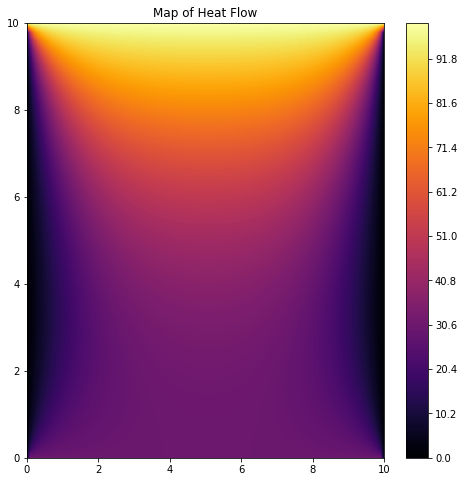

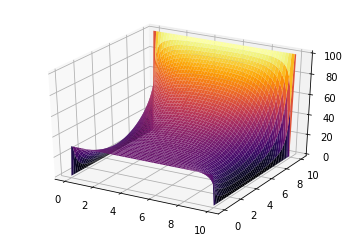

In [14]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Set the number of iterations to use when finding initial steady state
# This means we assume it converges within 550 iterations
maxiter = 500

# Set the number of time steps
nsteps = 1001

# Output figures at these timesteps
Tfigs = [0, 4, 25, 50, 100, 250, 500, 1000]
fignum = 0  # Will act as an index for generating figures

# Set dimensions of our plate
w, h = 10, 10

# thermal diffusivity, note that this is the same as alpha^2 from the heat flow equation.
D = 4  # Thermal diffusivity of steel, mm2.s-1
# D = 1  # Keep it simple.

# set the cartesian area elements
dx, dy = 0.1, 0.2

# SEE: second derivatives of spatially-dependent terms
dx2, dy2 = (dx*dx), (dy*dy)
dt = dx2*dy2 / (2 * D * (dx2 + dy2))

# number of discrete points in each cardinal direction
nx, ny = int(w/dx), int(h/dy)

# Relaxation Method: Initial guess of interior temp
# This is for finding the initial steady state
Tguess = 20

# Initialize the array we'll do calculations on
# and set the interior value to Tguess
u0_ = np.empty((nx, ny))
u0_.fill(Tguess)

# Bountary conditions
Ttop = 100
Tbottom = 30
Tleft = 0
Tright = 0

# Set a meshgrid, analagous to the graph drawn above
# This represents the discrete points across the grid
# We'll use this to plot the solution
X, Y = np.mgrid[0:w:nx*1j, 0:h:ny*1j]

# Set boundary conditions for the steady state before t=0
u0_[:, :1] = Tbottom
u0_[(nx-1):, :] = Tright
u0_[:1, :] = Tleft
u0_[:, (ny-1):] = Ttop

# Print out our array of initial data points on our discretized rectangular plate
# Note that in order to orient the printed output we have to translate rows to columns
# then print it out backwards. Kind of silly!
# np.set_printoptions(threshold=np.inf)
print("Initial Temperatures across plate:\n", u0_.T[::-1])
# np.set_printoptions(threshold=1000)


def steady_state_dist(niter, w, h, nx, ny, T):
    for iteration in range(0, niter):
        for i in range(1, nx-1):
            for j in range(1, ny-1):
                T[i, j] = (0.25) * (T[i+1][j] + T[i-1][j] +
                                    T[i][j+1] + T[i][j-1])
    return T


# Find initial steady state and initialize array u
u0 = steady_state_dist(maxiter, w, h, nx, ny, u0_)
u = np.empty((nx, ny))

# Draw a contour plot of steady state distributions
colorinterpolation = 500
colorMap = plt.cm.inferno
plt.figure(figsize=[8, 8])
plt.title("Map of Heat Flow")
plt.contourf(X, Y, u0, colorinterpolation, cmap=colorMap)
plt.colorbar()

plt.show()

# Draw a 3D plot
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X=X, Y=Y, Z=u0, cmap=colorMap)

In [15]:
# New initial conditions, version 1
Ttop_new = 0
Tbottom_new = 100
Tleft_new = 100
Tright_new = 0

# Set new conditions for the steady state before t=0
u0[:, :5] = Tbottom_new
u0[(nx-5):, :] = Tright_new
u0[:5, :] = Tleft_new
u0[:, (ny-5):] = Ttop_new

In [17]:
Tinner_new = 200

# New initial conditions version 2 - ring of inner radius r, width dr centred at (cx,cy) (mm)
r, cx, cy = 1, 7, 2
r2 = r**2
for i in range(nx):
    for j in range(ny):
        p2 = (i*dx-cx)**2 + (j*dy-cy)**2
        if p2 < r2:
            u0[i, j] = Tinner_new

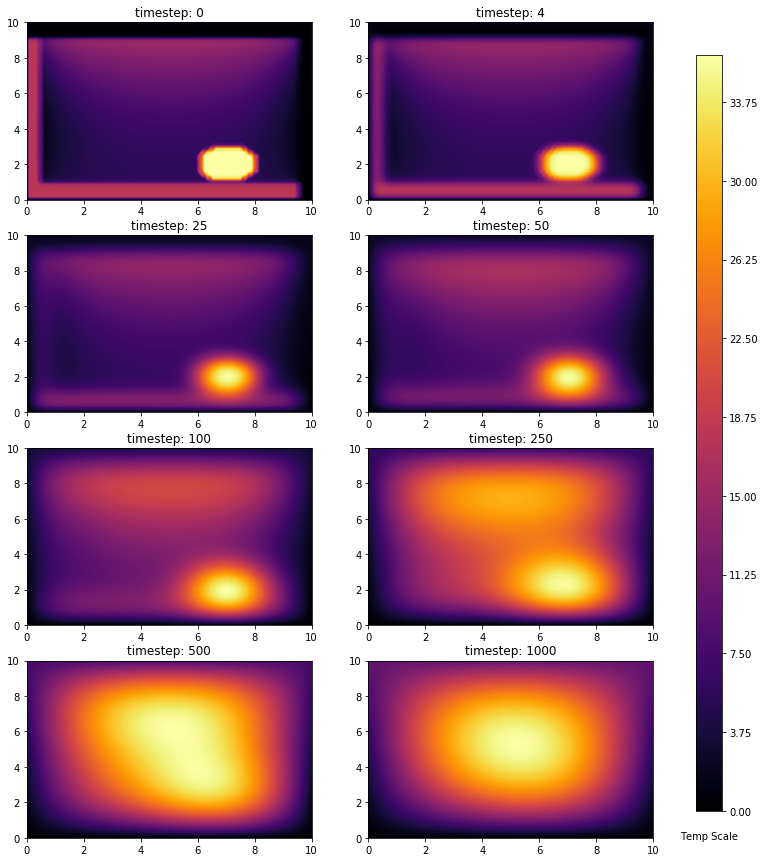

In [18]:
def do_timesteps(u0, u):
    # Propagate with forward-difference in time, central-difference in space
    u[1:-1, 1:-1] = u0[1:-1, 1:-1] + D * dt * (
        (u0[2:, 1:-1] - 2*u0[1:-1, 1:-1] + u0[:-2, 1:-1])/dx2
        + (u0[1:-1, 2:] - 2*u0[1:-1, 1:-1] + u0[1:-1, :-2])/dy2)

    u0[:] = u
    return u0, u


# Set the color interpolation and color map
# Color interpolation sets the number of regions of color... try changing it to see.
# 10 gives a color map with many tide lines, 250 gives a smooth, expensive map
colorinterpolation = 250
colorMap = plt.cm.inferno


# Run time series and draw heat flow snapshots
fig = plt.figure(figsize=[12, 15])
fignum = 0

for n in range(nsteps):
    u0, u = do_timesteps(u0, u)
    if n in Tfigs:
        fignum += 1
        ax = fig.add_subplot(420 + fignum)
        #im = ax.imshow(u.copy(), cmap=colorMap)
        im = ax.contourf(X, Y, u, colorinterpolation, cmap=colorMap)
        ax.set_title('timestep: {}'.format(n))

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
cbar_ax.set_xlabel('Temp Scale', labelpad=20)
fig.colorbar(im, cax=cbar_ax)
plt.show()

# Draw a 3D plot
#from mpl_toolkits.mplot3d import Axes3D
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#ax.plot_surface(X=X, Y=Y, Z=u0, cmap=colorMap)

### Warm Handprint on Surface (Cool!)

Check out this video of heat dissipating from a mattress... we're going to produce some results that look strikingly similar. <a href="https://www.youtube.com/watch?v=zsjxxX6voTQ">Video Link</a>

We've set the initial conditions to simulate a 98-degree farenheit human hand on a 63-degree surface. We let it get to a steady state, then remove the hand and watch the warmth fade.

<class 'numpy.ndarray'>


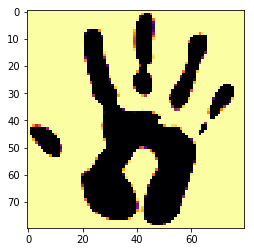

In [96]:
from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

image = rescale(rgb2gray(io.imread('hand.png')), 1.0 / 6.0,
                anti_aliasing=False, multichannel=False, mode='constant')

print(type(image))
plt.imshow(image, cmap='inferno')

In [97]:
image.shape

(80, 80)

In [98]:
for i in range(len(image)):
    for j in range(len(image[0])):
        if image[i, j] == 1:
            image[i, j] = 65
        else:
            image[i, j] = 90.7

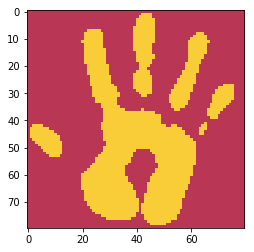

In [99]:
plt.imshow(image, cmap='inferno', vmin=32, vmax = 98.5);

In [101]:
type(image)

numpy.ndarray

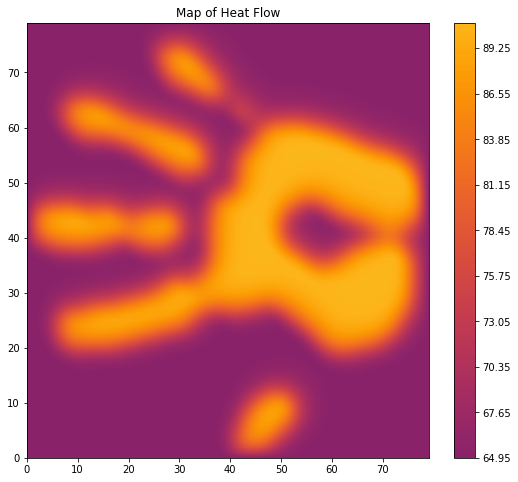

In [146]:
from numba import jit
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Set the number of iterations to use when finding initial steady state
# This means we assume it converges within 550 iterations
maxiter = 5

# Set the number of time steps
nsteps = 501

# Output figures at these timesteps
Tfigs = [0, 4, 25, 50, 100, 250, 500, 1000]
fignum = 0  # Will act as an index for generating figures

# Set dimensions of our plate
w, h = image.shape

# thermal diffusivity, note that this is the same as alpha^2 from the heat flow equation.
D = 4  # Thermal diffusivity of steel, mm2.s-1
# D = 1  # Keep it simple.

# set the cartesian area elements
dx, dy = 1, 1

# SEE: second derivatives of spatially-dependent terms
dx2, dy2 = (dx*dx), (dy*dy)
dt = dx2*dy2 / (2 * D * (dx2 + dy2))

# number of discrete points in each cardinal direction
nx, ny = int(w/dx), int(h/dy)

# Relaxation Method: Initial guess of interior temp
# This is for finding the initial steady state
Tguess = 20

# Initialize the array we'll do calculations on
# and set the interior value to Tguess
u0_ = image.copy()

# Set a meshgrid, analagous to the graph drawn above
# This represents the discrete points across the grid
# We'll use this to plot the solution
X, Y = np.mgrid[0:w:nx*1j, 0:h:ny*1j]


def steady_state_dist(niter, w, h, nx, ny, T):
    for iteration in range(0, niter):
        for i in range(1, nx-1):
            for j in range(1, ny-1):
                T[i, j] = (0.25) * (T[i+1][j] + T[i-1][j] +
                                    T[i][j+1] + T[i][j-1])
    return T


# Find initial steady state and initialize array u
u0 = steady_state_dist(maxiter, w, h, nx, ny, u0_)
u = u0[:]

# Draw a contour plot of steady state distributions
colorinterpolation = 250
colorMap = plt.cm.inferno
plt.figure(figsize=[9, 8])
plt.title("Map of Heat Flow")
plt.contourf(u0.T, colorinterpolation, cmap=colorMap, vmin=44, vmax=100)
plt.colorbar()

plt.show()

In [129]:
def do_timesteps(u0, u):
    # Propagate with forward-difference in time, central-difference in space
    u[1:-1, 1:-1] = u0[1:-1, 1:-1] + D * dt * (
        (u0[2:, 1:-1] - 2*u0[1:-1, 1:-1] + u0[:-2, 1:-1])/dx2
        + (u0[1:-1, 2:] - 2*u0[1:-1, 1:-1] + u0[1:-1, :-2])/dy2)

    u0[:] = u
    return u0, u

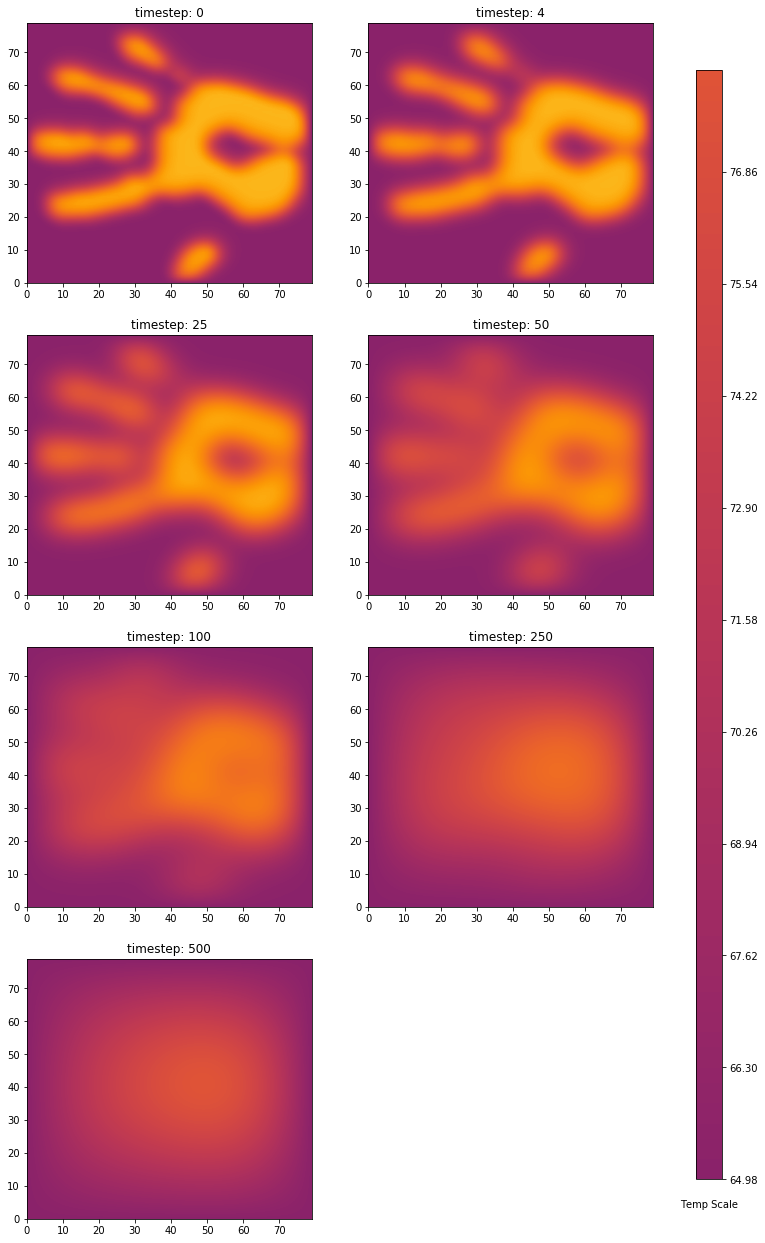

In [130]:
# Run time series and draw heat flow snapshots
fig = plt.figure(figsize=[12, 22])
fignum = 0

for n in range(nsteps):
    u0, u = do_timesteps(u0, u)
    if n in Tfigs:
        fignum += 1
        ax = fig.add_subplot(420 + fignum)
        im = ax.contourf(u.T, colorinterpolation,
                         cmap=colorMap, vmin=44, vmax=100)
        ax.set_title('timestep: {}'.format(n))

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
cbar_ax.set_xlabel('Temp Scale', labelpad=20)
fig.colorbar(im, cax=cbar_ax)
plt.show()

# Draw a 3D plot
#from mpl_toolkits.mplot3d import Axes3D
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#ax.plot_surface(X=X, Y=Y, Z=u0, cmap=colorMap)

## Circulation, Curl, and Stokes' Theorem; the Fundamental Theorems of Vector Calculus
from https://mathinsight.org/thread/math2374 

From the Math Insights link above, take thorough reading notes for the Parts listed below.

__Part 12__ (all sections, but particularly the sections related to curl)

__Part 14__ (all sections)

__Part 16__ (all sections, with particular attention to "A path-dependent vector field with zero curl")

__Part 22__ (all three sections)

__Part 26__: The integrals of multivariable calculus (but skim/skimp sections on Surface Integrals)

__Part 26__: The fundamental theorems of vector calculus